**Calculate the Safety Probability of Networked Multi-Agent Systems using Feynman-Kac Formula**

This code solves the following 3D convection-diffusion equation with respect to $\pi(x,y,t)$ on an orthotope $\mathcal{C}$ under the Dirichlet boundary condition: 

$$
\dfrac{\partial\pi}{\partial t} = y\dfrac{\partial\pi}{\partial x} - ((\lambda+\beta_1)x + \beta_2 y)\dfrac{\partial\pi}{\partial y} + \dfrac{1}{2}\sigma^2\left(\dfrac{\partial^2\pi}{\partial x^2} + \dfrac{\partial^2\pi}{\partial y^2}\right)\quad \mathrm{in}\ \ \mathbb{R}_{+}\times\mathcal{C}
$$

where $\lambda, \sigma$ are positive scalar parameters. Especially, $\lambda$ is an eigenvalue of the graph laplacian $\mathcal{L}$. 

1


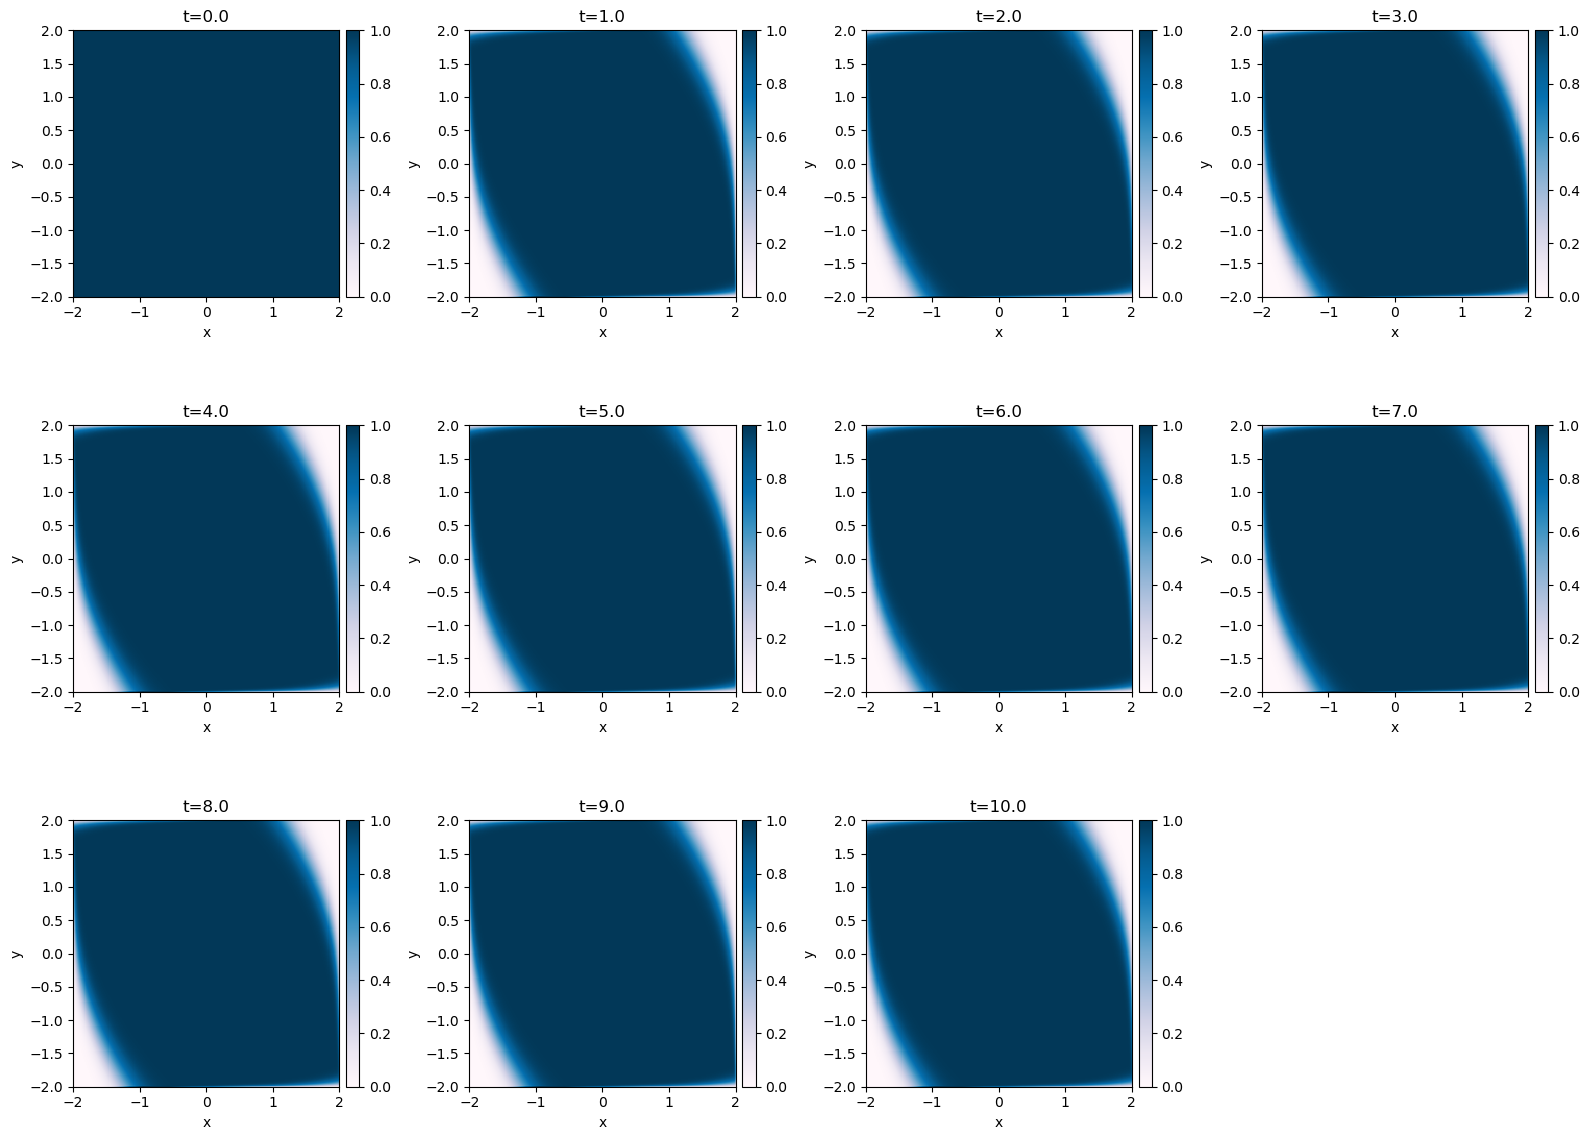

1.7090999999999998


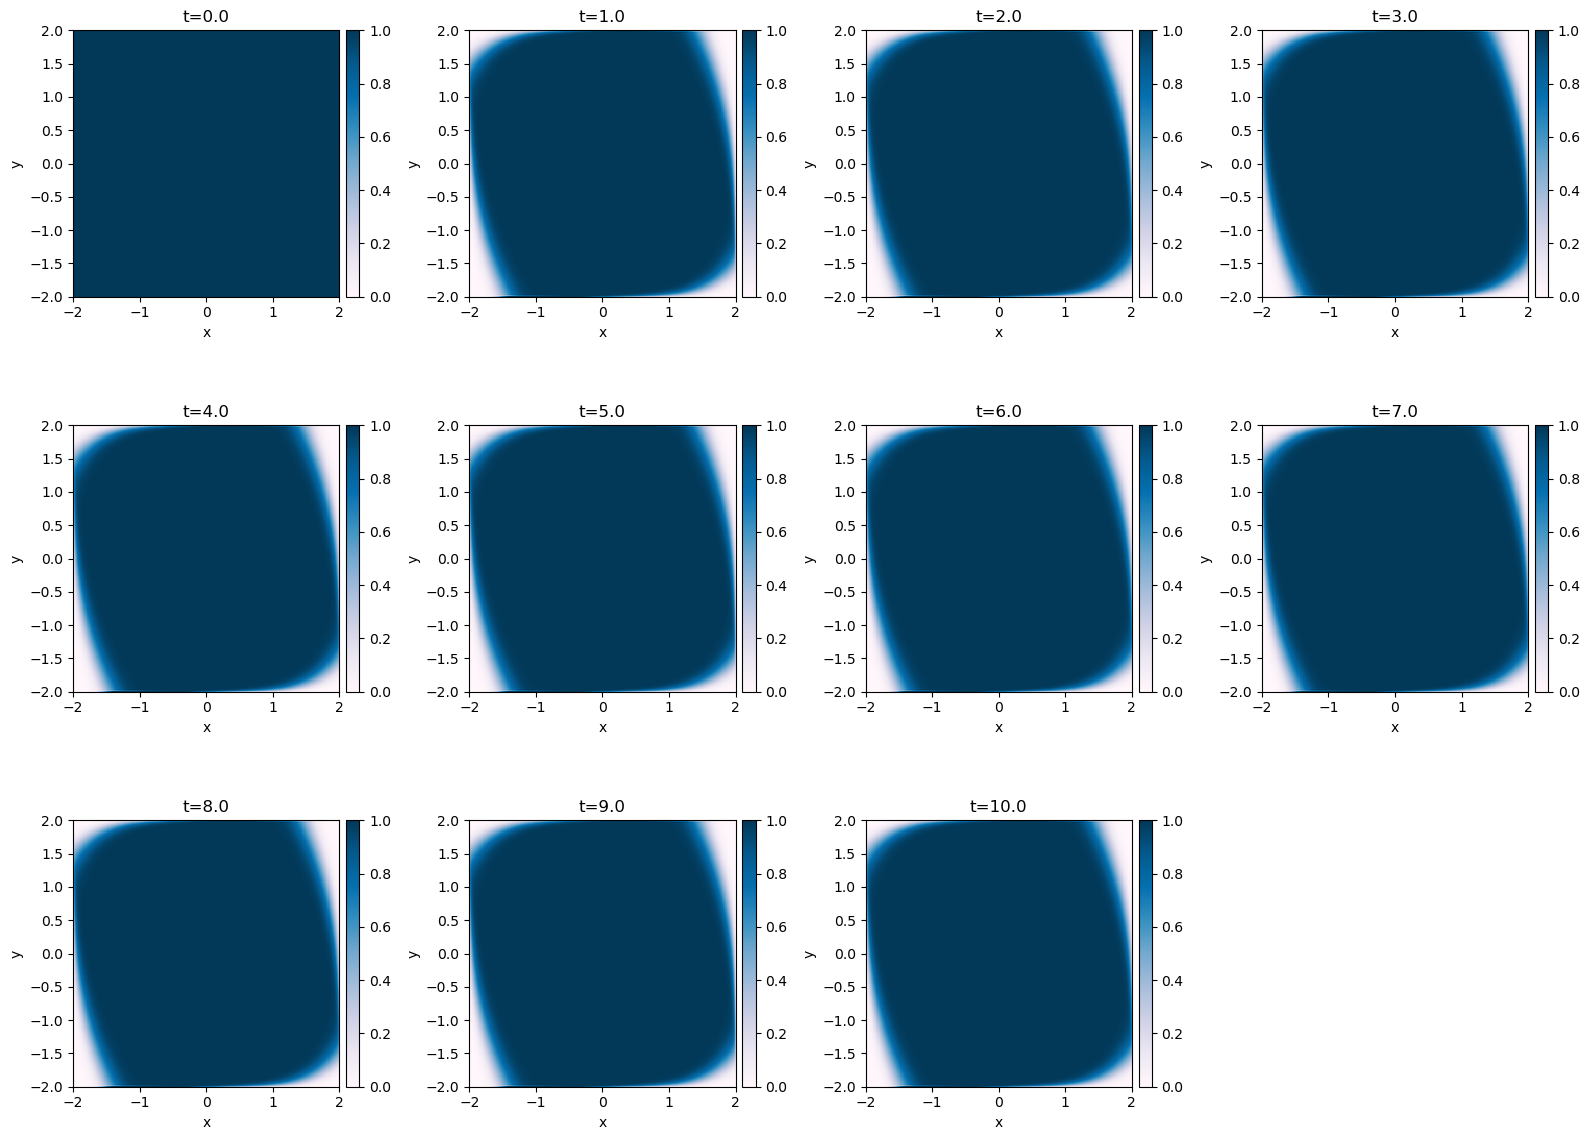

3.0567


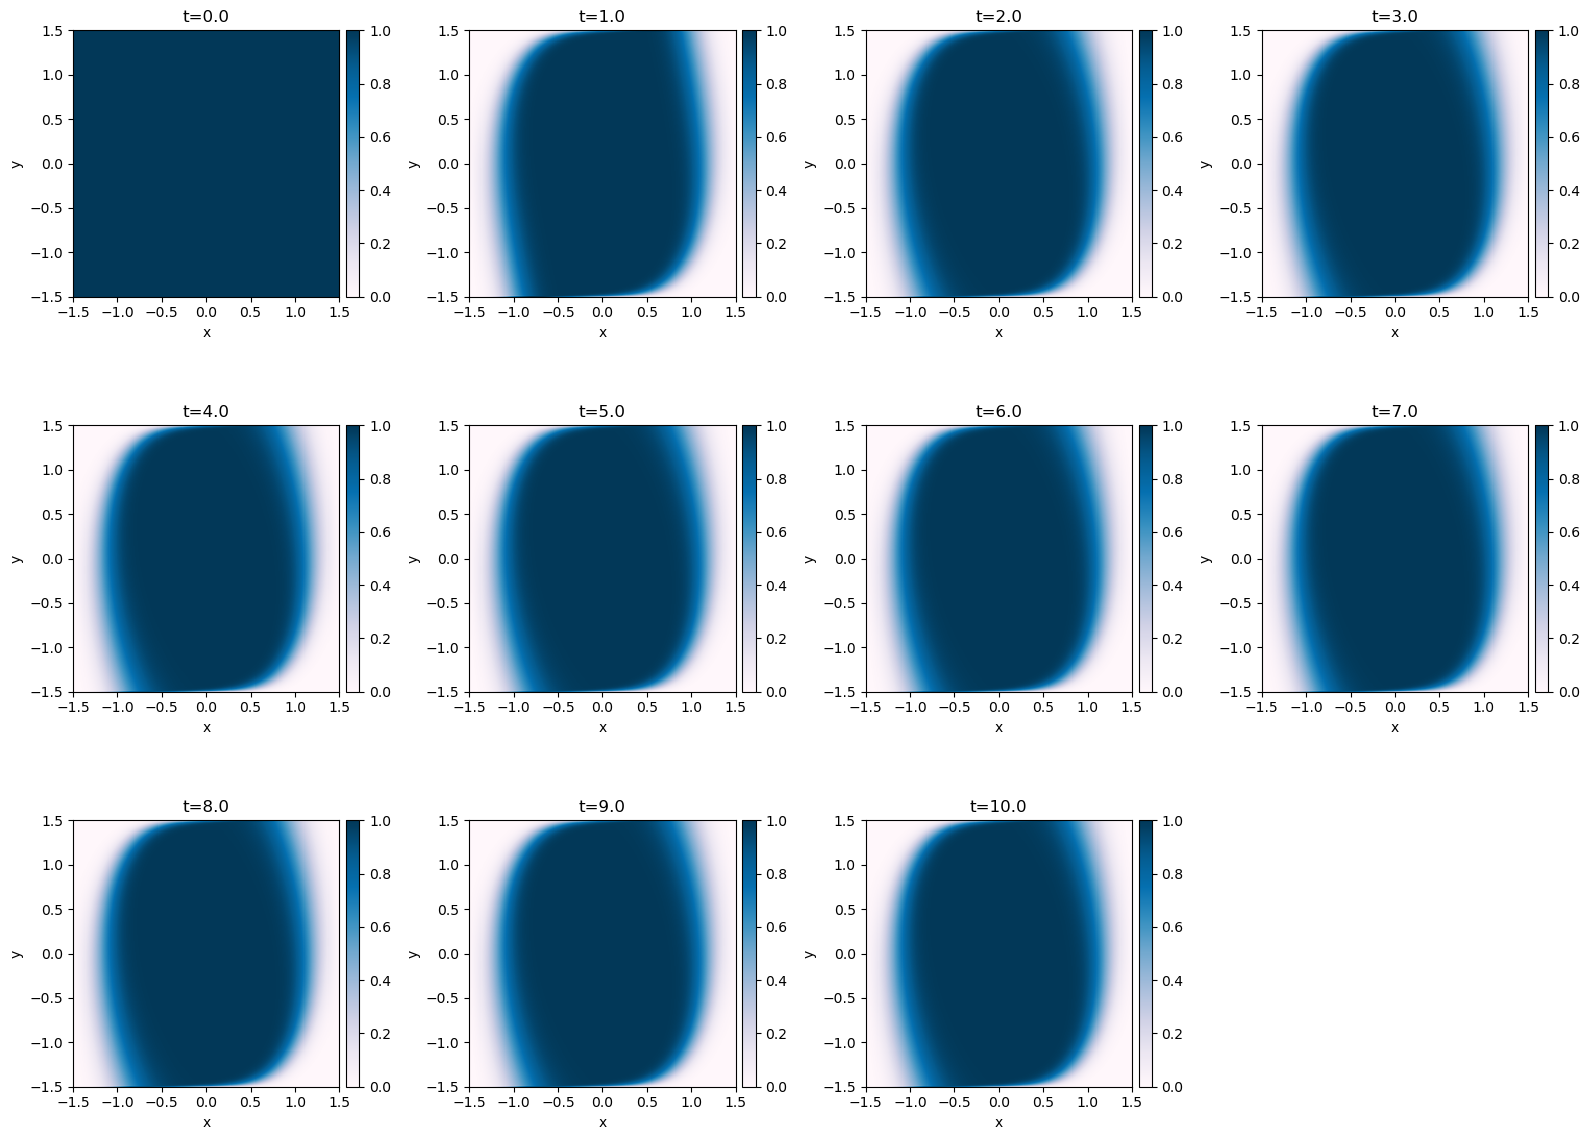

4.1134


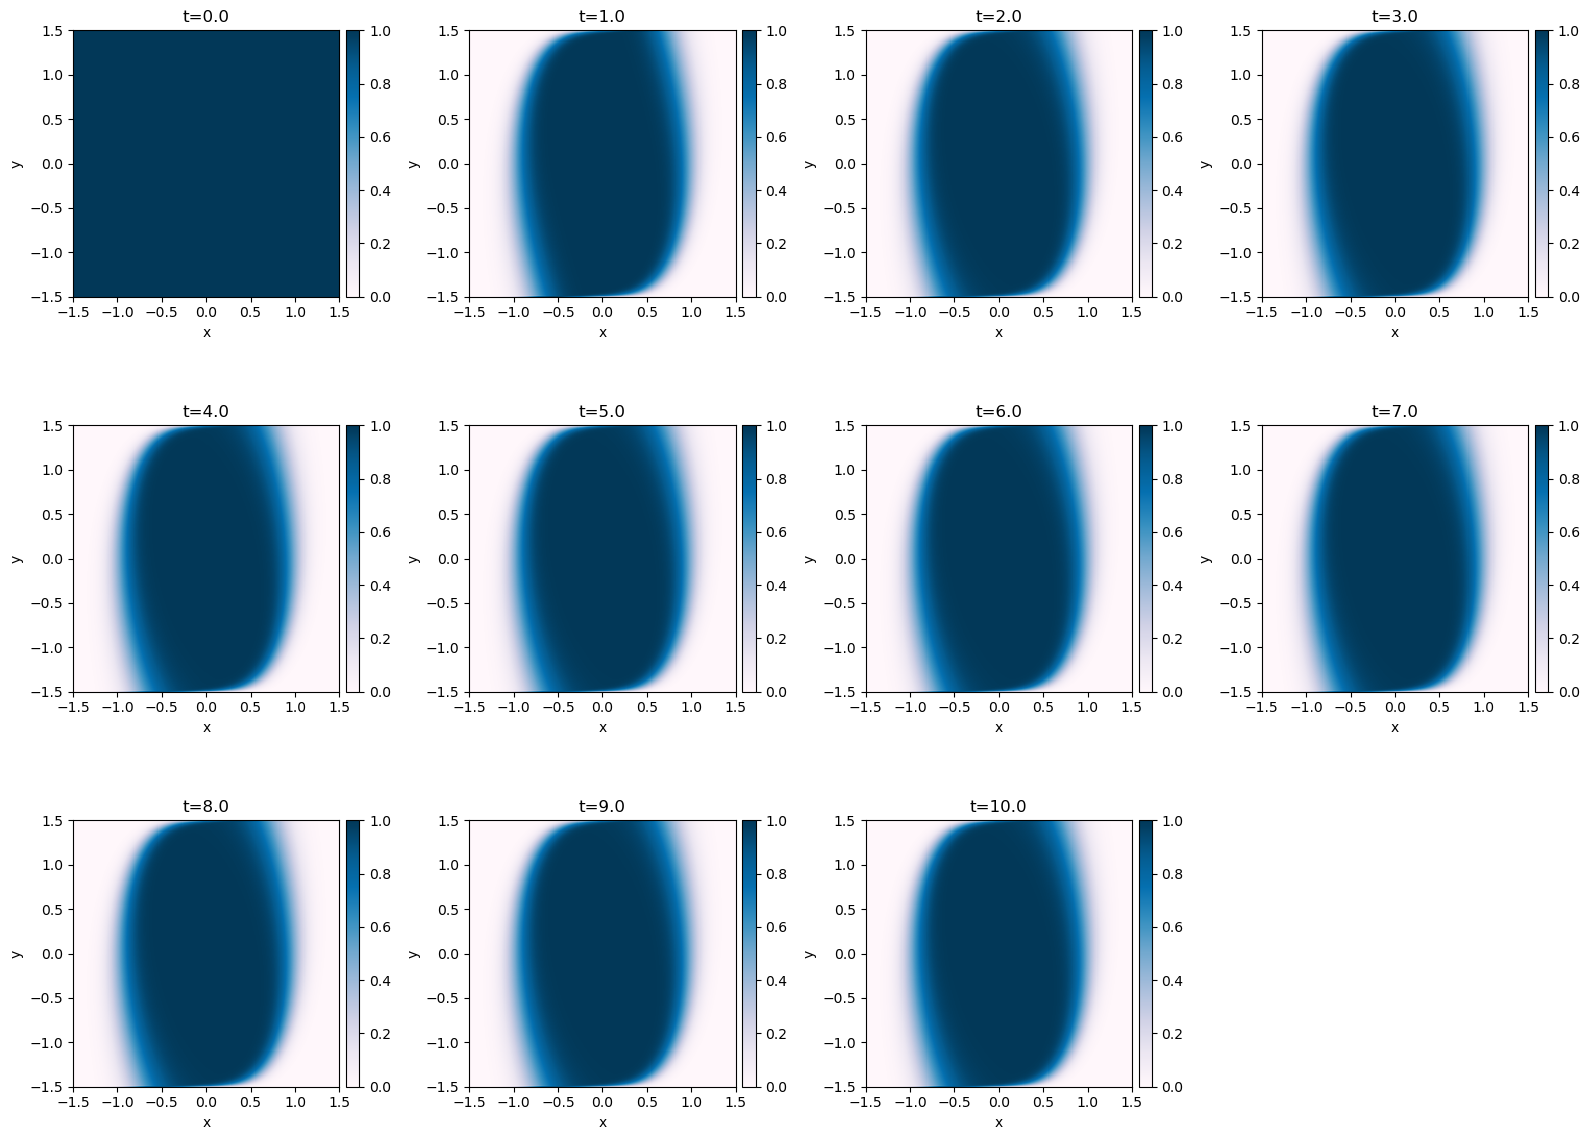

5.6842


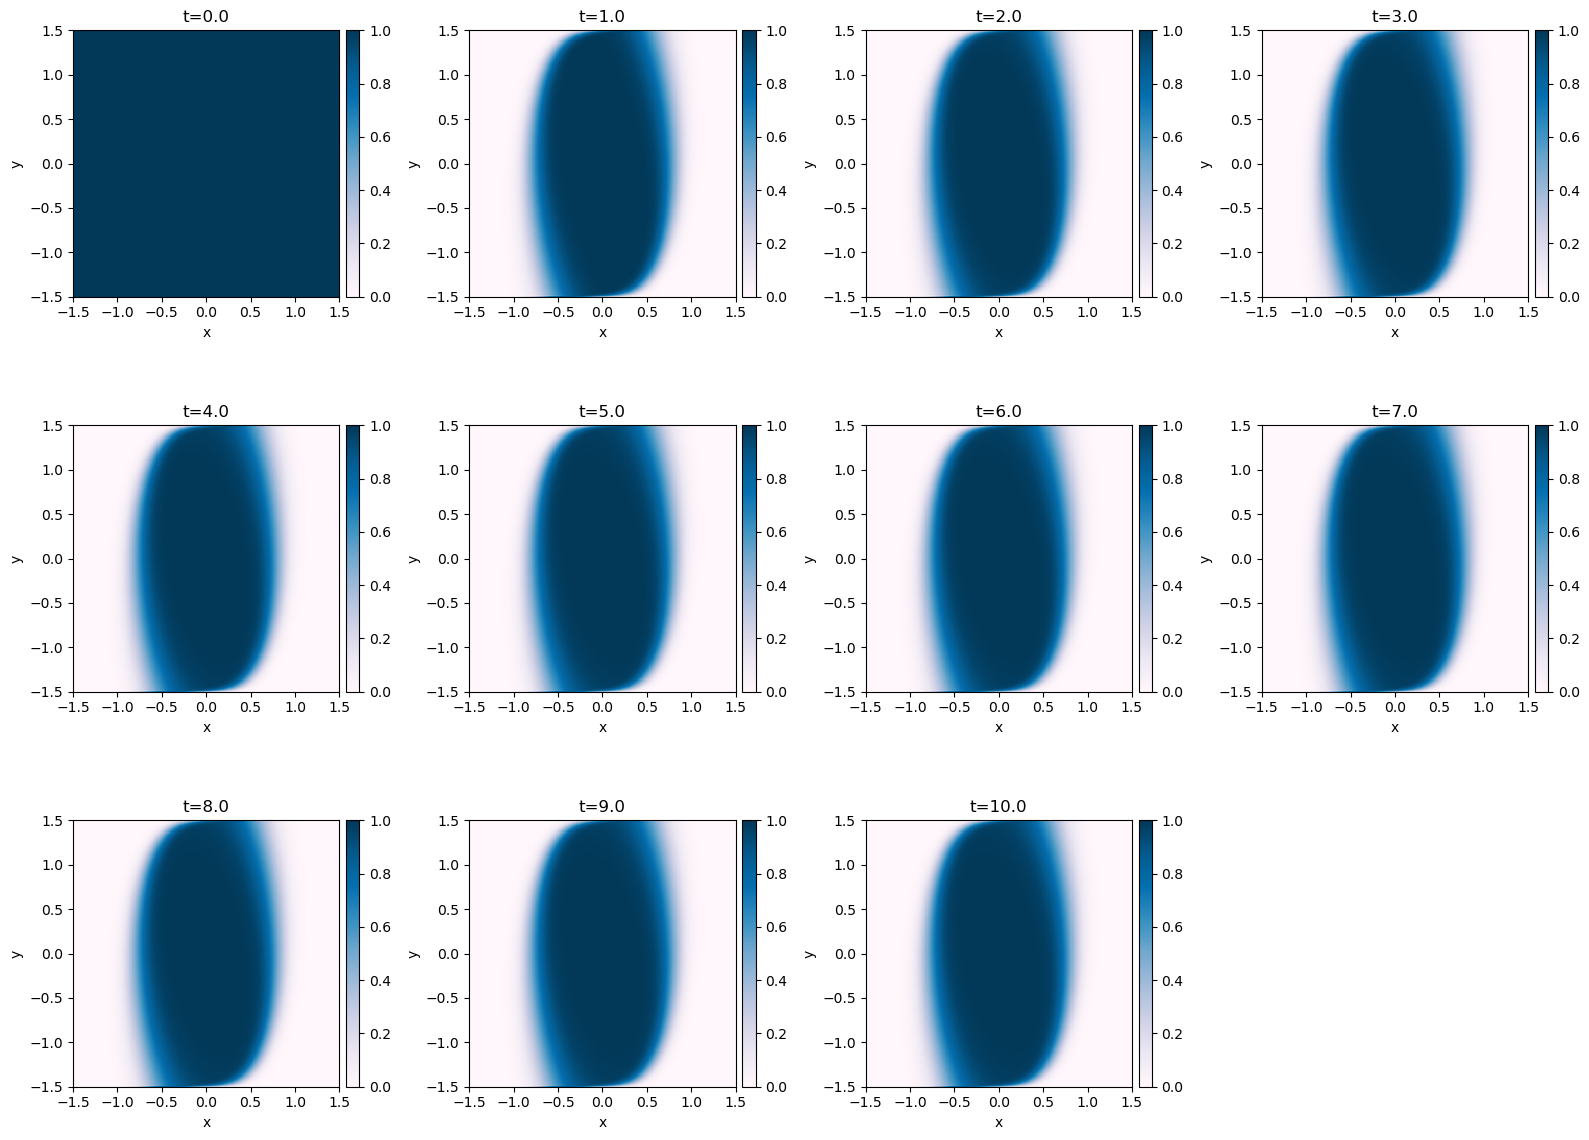

6.3759


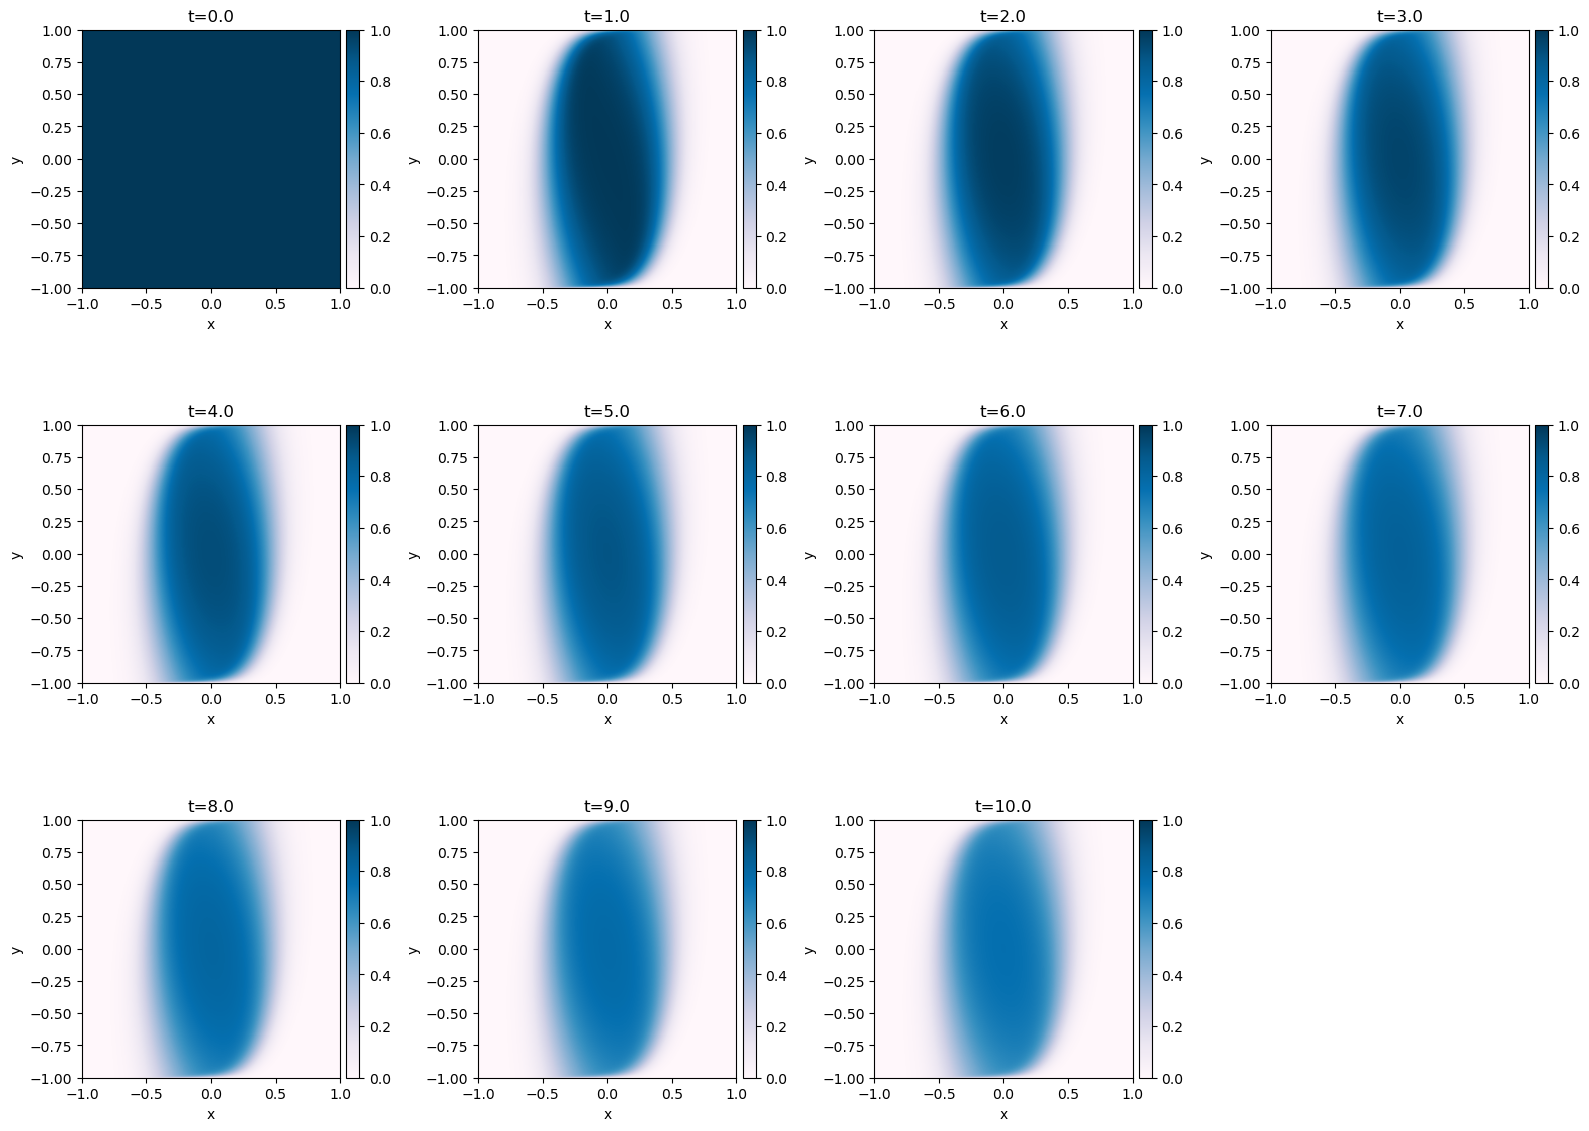

7.0607


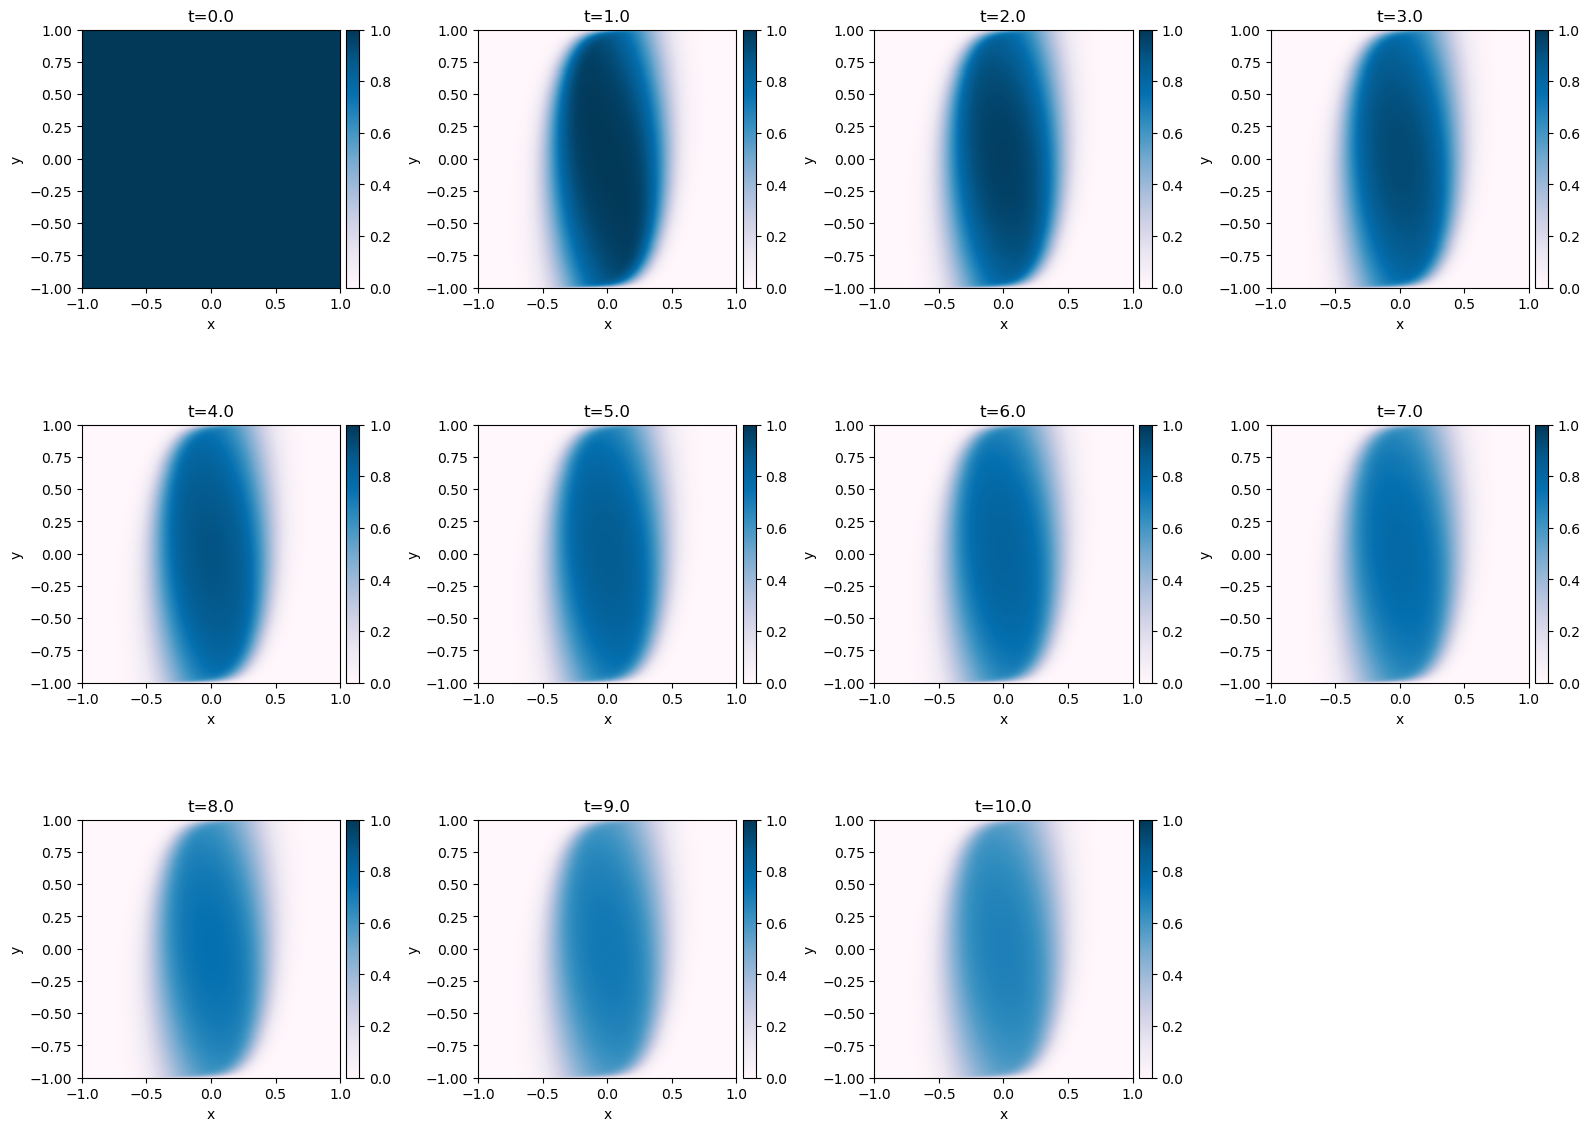

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pde import CartesianGrid, ScalarField, PDEBase, MemoryStorage
from scipy.io import savemat


# Parameter Settings
beta_1 = 1
beta_2 = 1
terminal_time = 10 # NOTE: The terminal time must be specified as an integer.

N = 7
lambda_val = [0, 0.7091, 2.0567, 3.1134, 4.6842, 5.3759, 6.0607]
threshold = [2, 2, 1.5, 1.5, 1.5, 1.0, 1.0]

for mode_num in range(N):
    theta = beta_1 + lambda_val[mode_num]
    sigma = 0.2

    print(theta)

    # Define the PDE
    class FeynmanKacPDE(PDEBase):
        def __init__(self, theta, sigma, bc='dirichlet'):
            self.theta = theta
            self.sigma = sigma
            self.bc = bc

        def evolution_rate(self, state, t=0):
            """ evaluate the right-hand side of the PDE """
            state_gradient = state.gradient(bc=self.bc)
            state_laplacian = state.laplace(bc=self.bc)
            x, y = state.grid.cell_coords[..., 0], state.grid.cell_coords[..., 1]

            # Calculate the components
            advection_x = y * state_gradient[0]
            advection_y = - (self.theta* x + beta_2 * y) * state_gradient[1]
            diffusion = (self.sigma**2 / 2) * state_laplacian

            return advection_x + advection_y + diffusion


    # Create the spatial grid
    grid = CartesianGrid([[-threshold[mode_num], threshold[mode_num]], [-threshold[mode_num], threshold[mode_num]]], [256, 256])

    # Initial conditions
    ic = ScalarField(grid, 1)

    # Instantiate the PDE
    pde = FeynmanKacPDE(theta, sigma)


    # Solve the PDE and store the results
    sampling_interval = 0.1
    storage = MemoryStorage()
    pde.solve(ic, t_range=10, dt=1e-4, tracker=storage.tracker(sampling_interval))


    # Save the data for MATLAB analysis with labeled filename and variable name
    data_filename = f'SafeProb_FKdata_(lambda_{mode_num},sigma={sigma}).mat'
    data_variable_name = f'data_lambda_{mode_num}'
    savemat(data_filename, {data_variable_name: np.array(storage.data), 'times': storage.times})


    # Extract the stored data for t = 0, 1, 2, ..., terminal_time
    times_to_plot = np.linspace(0, terminal_time, terminal_time + 1)
    fields = []
    for t in times_to_plot:
        # Find the index of the closest time in storage
        closest_index = np.argmin(np.abs(storage.times - t))
        field_data = storage.data[closest_index]
        field = ScalarField(grid, field_data)
        fields.append(field)


    # Plot the results
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    for ax, field, t in zip(axes.flat[:11], fields, times_to_plot):
        plot = field.plot(ax=ax, title=f't={t:.1f}', vmin=0, vmax=1, cmap='PuBu')  # Set colorbar range and colormap


    # Remove the last empty subplot
    fig.delaxes(axes.flat[-1])
    plt.tight_layout()
    plt.show()


    # Create directory for saving figures
    figures_dir = 'Figures'
    os.makedirs(figures_dir, exist_ok=True)


    # Save the plots with specified file names
    for t, field in zip(times_to_plot, fields):
        filename = f'{figures_dir}/SafeProb_FKsol(lambda={lambda_val[mode_num]},sigma={sigma},t={t}).svg'
        fig, ax = plt.subplots()
        field.plot(ax=ax, title=f't={t:.1f}', vmin=0, vmax=1, cmap='PuBu')
        plt.savefig(filename)
        plt.close(fig)